In [130]:
%matplotlib widget
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
from models import Net_4_layers_v1 as CurrentModel

Import data.

In [131]:
data_a = np.load("../data/dataset_all_L1_bootstrap_O3a.npy")
data_b = np.load("../data/dataset_all_L1_bootstrap_O3b.npy")
data_total = np.vstack([data_a, data_b])

Refering data.

In [132]:
pd.DataFrame(data_total)

,0,1,2,3,4,5,6
0,48.781016,125.678058,64.377699,13.839330,-0.343848,-0.489326,2.0
1,7.102618,3.503689,195.420034,36.615530,0.182109,0.165593,6.0
2,9.847253,6.826999,156.981292,22.675354,-0.244558,0.127793,0.0
3,11.866210,11.687671,104.986351,26.271004,-0.353925,0.200372,4.0
4,8.195894,1.366923,462.716205,76.756144,0.496335,-0.349955,6.0
...,...,...,...,...,...,...,...
284195,7.575335,2.296712,64.940880,9.794634,-0.356632,-0.200146,1.0
284196,8.720601,2.493930,216.532517,48.990571,-0.293408,0.009836,4.0
284197,8.919429,3.780447,492.737396,77.187800,-0.159196,0.284880,6.0
284198,323.756992,4765.712063,99.613206,11.783682,-0.426658,0.514562,2.0


Divide data into training set, validating set and testing set.

In [133]:
data_length = len(data_total)

training_set_length = int(data_length * 0.7)
validating_set_length = int(data_length * 0.2)
testing_set_length = data_length - training_set_length - validating_set_length

training_set = data_total[0:training_set_length, :]
validating_set = data_total[training_set_length:training_set_length + validating_set_length, :]
testing_set = data_total[training_set_length+validating_set_length:, :]

Determine the device.

In [134]:
filtered_data = testing_set[testing_set[:, -1] == 0]

# Print the number of rows
print(len(filtered_data))

4053


In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Make the data suitable to pytorch.

In [136]:
input_tensor_training = torch.tensor(training_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_training = torch.tensor(training_set[:, 6], dtype=torch.int64).to(device)

input_tensor_validating = torch.tensor(validating_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_validating = torch.tensor(validating_set[:, 6], dtype=torch.int64).to(device)

input_tensor_testing = torch.tensor(testing_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_testing = torch.tensor(testing_set[:, 6], dtype=torch.int64).to(device)

dataset_training = TensorDataset(input_tensor_training, label_tensor_training)
dataset_validating = TensorDataset(input_tensor_validating, label_tensor_validating)
dataset_testing = TensorDataset(input_tensor_testing, label_tensor_testing)

loader_training = DataLoader(dataset_training, batch_size=32, shuffle=True)
loader_validating = DataLoader(dataset_validating, batch_size=32, shuffle=True)
loader_testing = DataLoader(dataset_testing, batch_size=32, shuffle=True)

Define the model, criterion and optimizer.

In [137]:
model = CurrentModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0000025)


In [138]:
import torch
import torch.nn.functional as F

#Your training loop
loss_average_list = []
accuracy_average_list = []
valid_loss_average_list = []
valid_accuracy_average_list = []
test_loss_average_list = []
test_accuracy_average_list = []

for epoch in tqdm(range(10000), desc="Training ..."):
    model.train()  # Set the model to training mode
    correct_predictions = 0
    total_samples = 0
    loss_array = []

    for data in loader_training:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_array.append(loss.item())

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    loss_average = sum(loss_array) / len(loss_array)
    accuracy_average = correct_predictions / total_samples
    loss_average_list.append(loss_average)
    accuracy_average_list.append(accuracy_average)

    #validation loop
    model.eval()  
    correct_predictions_valid = 0
    total_samples_valid = 0
    loss_array_valid = []

    with torch.no_grad():  # Disable gradient computation during testing
        for data in loader_validating:
            inputs_test, labels_test = data[0].to(device), data[1].to(device)
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            loss_array_valid.append(loss_test.item())

            _, predicted_test = torch.max(outputs_test, 1)
            correct_predictions_valid += (predicted_test == labels_test).sum().item()
            total_samples_valid += labels_test.size(0)

    loss_average_valid = sum(loss_array_valid) / len(loss_array_valid)
    accuracy_average_valid = correct_predictions_valid / total_samples_valid

    valid_loss_average_list.append(loss_average_valid)
    valid_accuracy_average_list.append(accuracy_average_valid)

    #testing loop
    model.eval()
    correct_predictions_test = 0
    total_samples_test = 0
    loss_array_test = []
    probabilities_class_1_test = []  # To store probabilities for class 1 in the testing set

    with torch.no_grad():  # Disable gradient computation during testing
        for data_test in loader_testing:
            inputs_test, labels_test = data_test[0].to(device), data_test[1].to(device)
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            loss_array_test.append(loss_test.item())

            _, predicted_test = torch.max(outputs_test, 1)

            # Filter instances where the actual label is 0 (injections)
            indices_class_1 = (labels_test == 0).nonzero()
            
            # Extract probabilities for class 0 and corresponding indices
            probabilities_class_1_test.extend(F.softmax(outputs_test, dim=1)[:, 0][indices_class_1].cpu().numpy())

            correct_predictions_test += (predicted_test == labels_test).sum().item()
            total_samples_test += labels_test.size(0)

    loss_average_test = sum(loss_array_test) / len(loss_array_test)
    accuracy_average_test = correct_predictions_test / total_samples_test

    test_loss_average_list.append(loss_average_test)
    test_accuracy_average_list.append(accuracy_average_test)

probabilities_class_1_array = np.array(probabilities_class_1_test)


Training ...: 100%|██████████| 10000/10000 [13:41:24<00:00,  4.93s/it] 


Plot the loss and average.

In [141]:
#model_name = "AdamSoftmaxV10k"

#with open(model_name + 'Loss.txt', 'w') as file:
 #  file.write('\n'.join(map(str, loss_average_list)))
    
#with open(model_name + 'Acc.txt', 'w') as file:
 #  file.write('\n'.join(map(str, accuracy_average_list)))

#with open(model_name + 'ValidLoss.txt', 'w') as file:
 #  file.write('\n'.join(map(str, valid_loss_average_list)))
    
#with open(model_name + 'ValidAcc.txt', 'w') as file:
 #  file.write('\n'.join(map(str, valid_accuracy_average_list)))
   
#with open(model_name + "TestLoss.txt", 'w') as file:
 #  file.write('\n'.join(map(str, test_loss_average_list)))
   
with open("LProbabilities10k.txt", 'w') as file:
   file.write('\n'.join(map(str, probabilities_class_1_array)))

In [139]:
values = [loss_average_list[-1],accuracy_average_list[-1],valid_loss_average_list[-1],valid_accuracy_average_list[-1],test_loss_average_list[-1],test_accuracy_average_list[-1]]
print(values)

[0.30112675345447815, 0.8992610837438424, 0.3363569740962801, 0.8970795214637579, 0.3154676734848017, 0.8965165376495425]


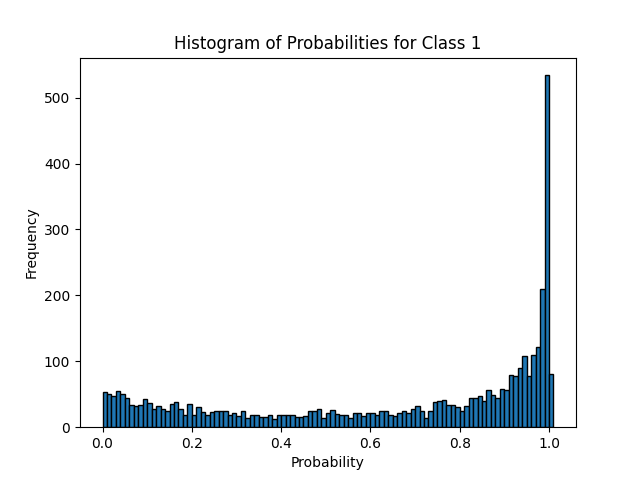

4053


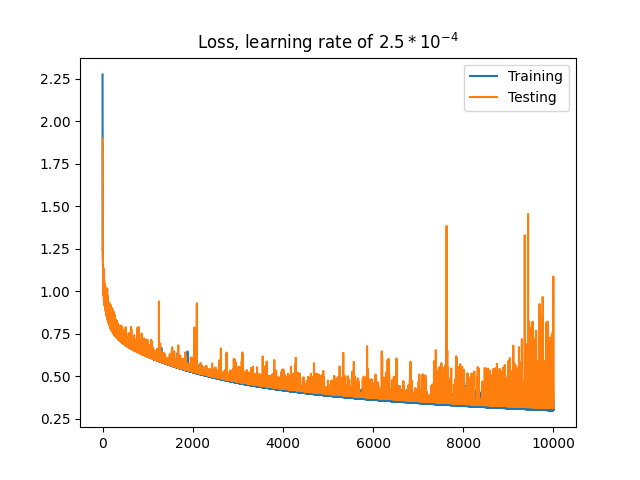

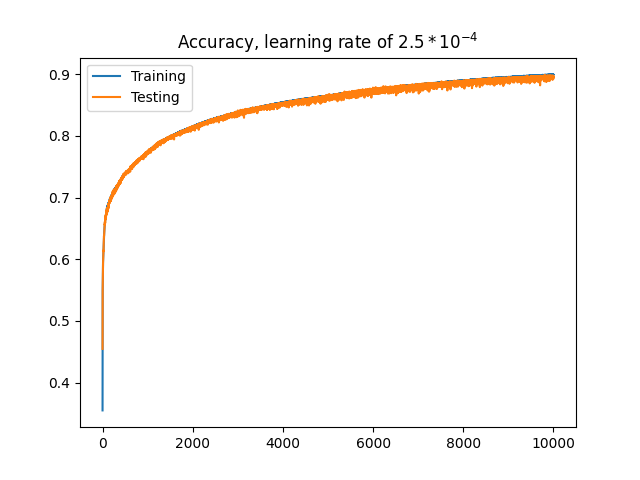

In [140]:
import matplotlib.pyplot as plt


fig1, ax1 = plt.subplots()
ax1.plot(loss_average_list, label="Training")
#ax1.plot(valid_loss_average_list, label="Validation")
ax1.plot(test_loss_average_list, label="Testing")

#ax1.set_yscale("log")
ax1.legend()
ax1.set_title("Loss, learning rate of $2.5*10^{-4}$")


fig2, ax2 = plt.subplots()
ax2.plot(accuracy_average_list, label="Training")
#ax2.plot(valid_accuracy_average_list, label="Validation")
ax2.plot(test_accuracy_average_list, label="Testing")
ax2.legend()
ax2.set_title("Accuracy, learning rate of $2.5*10^{-4}$")

fig3, ax3 = plt.subplots()
bin_width = 0.01
bins = [i * bin_width for i in range(int((probabilities_class_1_array.max() - probabilities_class_1_array.min()) / bin_width) + 2)]

ax3.hist(probabilities_class_1_array, bins=bins, edgecolor='black')
ax3.set_title('Histogram of Probabilities for Class 1')
ax3.set_xlabel('Probability')
ax3.set_ylabel('Frequency')

plt.show()

print(len(probabilities_class_1_array))

Judge the model.

In [143]:
model.eval()
all_predictions = []
all_labels = []

In [145]:
with torch.no_grad():
    for inputs, labels in loader_testing:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Calculate accuracy.

In [146]:
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8965165376495425


In [147]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.84      0.70      0.77      4053
           1       0.98      0.97      0.97      4080
           2       0.97      0.96      0.96      4120
           3       0.90      0.97      0.93      4100
           4       0.82      0.84      0.83      4063
           5       0.97      1.00      0.99      4005
           6       0.80      0.83      0.81      3999

    accuracy                           0.90     28420
   macro avg       0.90      0.90      0.89     28420
weighted avg       0.90      0.90      0.89     28420



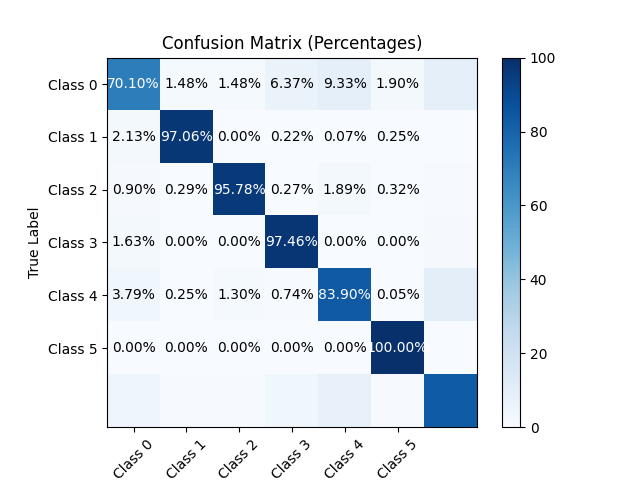

In [148]:
cm = confusion_matrix(all_labels, all_predictions)

# Calculate the confusion matrix with percentages
cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

# Save confusion matrix with percentages to a text file
np.savetxt("Lconfusion_matrix.txt", cm_percentage, fmt="%.2f", delimiter="\t")

plt.figure()

# Visualize the confusion matrix as a heatmap with percentages
plt.imshow(cm_percentage, interpolation="nearest", cmap=plt.cm.Blues, vmin=0, vmax=100)
plt.title("Confusion Matrix (Percentages)")
plt.colorbar()

# Labeling the axes
classes = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]#, "Class 6"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Display the percentages in each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f"{cm_percentage[i, j]:.2f}%", ha="center", va="center", color="white" if cm_percentage[i, j] > 50 else "black")

# Show the plot or save it to a file
#plt.savefig("confusion_matrix_percentage_heatmap.png", bbox_inches="tight")
plt.show()

Save the model.

In [20]:
torch.save(model.state_dict(), "../models/" + model_name)

Load the model.

In [19]:
model = CurrentModel().to(device)
model.load_state_dict(torch.load("../models/" + model_name))

<All keys matched successfully>